In [56]:
from Models import *
from Utils import *
from FastModels import *
import warnings
from livelossplot import PlotLossesKeras
# warnings.filterwarnings('ignore')

In [57]:
from gensim.models import KeyedVectors
import sentencepiece as spm

max_len = 15
enablePadding = True

sp = spm.SentencePieceProcessor()
sp.Load('/work/data/bpe/en.wiki.bpe.op50000.model')
bpe = KeyedVectors.load_word2vec_format("/work/data/bpe/en.wiki.bpe.op50000.d200.w2v.bin", binary=True)
bpe.index2word = [''] + bpe.index2word + ['<sos>'] + ['<eos>']  # add empty string 
nb_words = len(bpe.index2word)
# word2index
bpe_dict = {bpe.index2word[i]: i for i in range(len(bpe.index2word))}
# construct embedding_matrix
embedding_matrix = np.concatenate([np.zeros((1, bpe.vector_size)), bpe.vectors, np.zeros((2, bpe.vector_size))]) # add zero vector for empty string (i.e. used for padding)

embedding_layer = Embedding(nb_words,
                    embedding_matrix.shape[-1],
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True)

In [58]:
enablePadding = True
df_july, qrel_july = get_test_data("JulyFlower", "/work/")
q_july = parse_texts_bpe(df_july.q.tolist(), sp, bpe_dict, max_len, enablePadding, "post")
d_july = parse_texts_bpe(df_july.d.tolist(), sp, bpe_dict, max_len, enablePadding, "post")

In [59]:
class Seq2Seq(object):
    
    def __init__(self, nb_words, max_len, embedding_matrix, dim, optimizer=Adam(), keep_rate_word_dropout=0.5):
        self.dim = dim
        self.nb_words = nb_words
        self.max_len = max_len
        self.embedding_matrix = embedding_matrix
        self.optimizer = optimizer
        self.keep_rate_word_dropout = keep_rate_word_dropout
        self.build()

    def build(self):
        hidden_dim = self.dim[0]
        latent_dim = self.dim[1]

        # Define an input sequence and process it.
        encoder_inputs = Input(shape=(self.max_len,))
        kl_inputs = Input(shape=(1,))
        encoder_embedding = Embedding(self.nb_words,
                                        self.embedding_matrix.shape[-1],
                                        weights=[self.embedding_matrix],
                                        input_length=self.max_len,
                                        mask_zero=True,
                                        trainable=True)

        encoder_lstm = GRU(hidden_dim, return_state=True)

        x = encoder_embedding(encoder_inputs)
        _, state = encoder_lstm(x)

        mean = Dense(latent_dim)
        var = Dense(latent_dim)

        state_mean = mean(state)
        state_var = var(state)

        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.shape(z_mean)[1]), mean=0.,\
                                      stddev=1)
            return z_mean + K.exp(z_log_var / 2) * epsilon 

        state_z = Lambda(sampling, name="kl")([state_mean, state_var])
        
        decoder_inputs = Input(shape=(self.max_len,))
        
        
        latent2hidden = Dense(hidden_dim)
        decoder_lstm = GRU(hidden_dim, return_sequences=True)
        decoder_dense = Dense(self.nb_words, activation='softmax', name="rec")
        
        
        x = encoder_embedding(decoder_inputs)
        decoder_outputs = decoder_lstm(x, initial_state=latent2hidden(state_z))
        rec_outputs = decoder_dense(decoder_outputs)

        def kl_loss(x, x_):
            kl_loss = - 0.5 * K.sum(1 + state_var - K.square(state_mean) - K.exp(state_var), axis=-1)
            return kl_inputs * kl_loss

        self.model = Model([encoder_inputs, decoder_inputs, kl_inputs], [rec_outputs, state_z])
        self.model.compile(optimizer=self.optimizer, loss=['sparse_categorical_crossentropy', kl_loss])
        self.encoder = Model(encoder_inputs, state_mean)

    def name(self):
        return "seq2seq"
    
    
    def word_dropout(self, x, unk_token):

        x_ = np.copy(x)
        rows, cols = np.nonzero(x_)
        for r, c in zip(rows, cols):
            if random.random() <= self.keep_rate_word_dropout:
                continue
            x_[r][c] = unk_token

        return x_


In [60]:
run = Seq2Seq(nb_words, max_len, embedding_matrix, [256,16])

In [38]:
anneal_function = 'logistic'
k = 0.005
x0 = int(3900/2)

In [39]:
def kl_anneal_function(anneal_function, step, k, x0):
    if anneal_function == 'logistic':
        return float(1/(1+np.exp(-k*(step-x0))))
    elif anneal_function == 'linear':
        return min(1, step/x0/2)

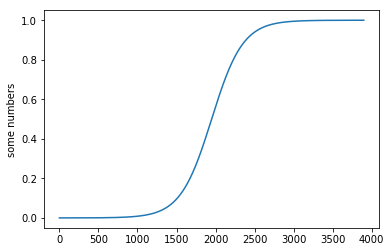

In [42]:
import matplotlib.pyplot as plt
import numpy as np
x = [kl_anneal_function(anneal_function, i, k, x0) for i in range(3900)]
plt.plot(x)
plt.ylabel('some numbers')
plt.show()

In [43]:
%%time
i = 0
rate = 1/10000000
for j in range(10000000):
    i = i + rate

CPU times: user 1.35 s, sys: 96 ms, total: 1.44 s
Wall time: 1.32 s


In [117]:
i

0.99999999975017

In [42]:
for i in range(100):
    kl_inputs = np.array([kl_anneal_function(anneal_function, i, k, x0)] * len(q_july))
    hist = run.model.fit([q_july, q_july, kl_inputs], [np.expand_dims(q_july, axis=-1), np.ones((len(q_july), 16))], verbose=0, epochs=1)
    
    print(i, eval_july(run.encoder), hist.history['rec_loss'], hist.history['kl_loss'])

ResourceExhaustedError: OOM when allocating tensor with shape[32,15,50512]
	 [[Node: training_3/Adam/gradients/rec_3/Max_grad/Equal = Equal[T=DT_FLOAT, _class=["loc:@rec_3/Max"], _device="/job:localhost/replica:0/task:0/gpu:0"](training_3/Adam/gradients/rec_3/Max_grad/Reshape, rec_3/add)]]
	 [[Node: training_3/Adam/gradients/gru_8/while/mul_3_grad/Reshape_1/_2671 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_584_training_3/Adam/gradients/gru_8/while/mul_3_grad/Reshape_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](^_clooptraining_3/Adam/gradients/AddN_7/_2344)]]

Caused by op 'training_3/Adam/gradients/rec_3/Max_grad/Equal', defined at:
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-4c2bf16429a8>", line 3, in <module>
    hist = run.model.fit([q_july, q_july, kl_inputs], [np.expand_dims(q_july, axis=-1), np.ones((len(q_july), 16))], verbose=0, epochs=1)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1608, in fit
    self._make_train_function()
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/optimizers.py", line 415, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2369, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 368, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 83, in _MaxGrad
    return _MinOrMaxGrad(op, grad)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 73, in _MinOrMaxGrad
    indicators = math_ops.cast(math_ops.equal(y, op.inputs[0]), grad.dtype)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 672, in equal
    result = _op_def_lib.apply_op("Equal", x=x, y=y, name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'rec_3/Max', defined at:
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/usr/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-3021bc4cb391>", line 1, in <module>
    run = Seq2Seq(nb_words, max_len, embedding_matrix, [256,16])
  File "<ipython-input-13-cd93525e1fb9>", line 9, in __init__
    self.build()
  File "<ipython-input-13-cd93525e1fb9>", line 54, in build
    rec_outputs = decoder_dense(decoder_outputs)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/layers/core.py", line 847, in call
    output = self.activation(output)
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/activations.py", line 26, in softmax
    e = K.exp(x - K.max(x, axis=axis, keepdims=True))
  File "/home/t-jamano/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1204, in max
    return tf.reduce_max(x, axis=axis, keep_dims=keepdims)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1451, in reduce_max
    name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1292, in _max
    keep_dims=keep_dims, name=name)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,15,50512]
	 [[Node: training_3/Adam/gradients/rec_3/Max_grad/Equal = Equal[T=DT_FLOAT, _class=["loc:@rec_3/Max"], _device="/job:localhost/replica:0/task:0/gpu:0"](training_3/Adam/gradients/rec_3/Max_grad/Reshape, rec_3/add)]]
	 [[Node: training_3/Adam/gradients/gru_8/while/mul_3_grad/Reshape_1/_2671 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_584_training_3/Adam/gradients/gru_8/while/mul_3_grad/Reshape_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](^_clooptraining_3/Adam/gradients/AddN_7/_2344)]]


In [10]:
def generate_output(model, bpe, x, nrows=100000, idx=None):

    gen_x = np.argmax(model.predict(x), axis=-1) if idx == None else np.argmax(model.predict(x)[idx], axis=-1)
    bleu = []
    results = []
    count = 0
    for i, k in zip(gen_x, x[0]):
        gen_x = " ".join([bpe.index2word[t] for t in i])
        real_x = " ".join([bpe.index2word[t] for t in k])

        bleu.append(sentence_bleu(real_x, gen_x))
        
        real_x = real_x.replace("▁the", "")
        real_x = real_x.replace("▁","")
        gen_x = gen_x.replace("▁the", "")
        gen_x = gen_x.replace("▁","")
        
        if count > nrows:
            break
        count = count + 1
        results.append("%s\t%s" % (real_x, gen_x))
        
    
    print("BLEU: %.4f" % np.mean(bleu))
    idx = np.arange(len(results))
    shuffle(idx)
    for i in idx[:nrows]:
        print(results[i])

In [19]:
generate_output(run.model, bpe, [q_july, q_july, np.ones((len(q_july)))], idx=0)

BLEU: 0.6193
great smoky mountains national park          	great smoky mountains national park park park park park park park park park park park
radio city music hall           	radio city music hall hall hall hall hall hall hall hall hall hall hall hall
che vy monte carlo           	che vy monte carlo carlo carlo carlo carlo carlo carlo carlo carlo carlo carlo carlo
types of cer ner certifications          	types of cer ner certifications certifications certifications certifications certifications certifications certifications certifications certifications certifications certifications
dawn of  planet of  apes review       	dawn of  planet of  apes review review review review review review review review
removing smoke smell from house          	removing smoke smell from house house house house house house house house house house house
cord of wood dimensions           	cord of wood dimensions dimensions dimensions dimensions dimensions dimensions dimensions dimensions dimensions dimen

In [36]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import wasserstein_distance
def eval_july(run, idx=None):
    q_ = run.predict(q_july)[idx] if idx != None else run.predict(q_july)
    d_ = run.predict(d_july)[idx] if idx != None else run.predict(d_july)
    cosine = CosineSim(q_.shape[-1])
    
    pred = []
    for i in range(len(q_)):
        pred.append(wasserstein_distance(q_[i], d_[i]))
    pred = np.array(pred)
    cos_pred = cosine.model.predict([q_, d_])
    return auc(qrel_july, pred.flatten()), auc(qrel_july, cos_pred.flatten())

(426, 16)


0.520847695078832